In [74]:
# %%
import os,argparse,natsort
import pandas as pd
import matplotlib.pyplot as plt
# display more columns
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [75]:
data_dir = '/mydata/iiswc24/lotus/lotustrace_vtune_result'
plot_path = '/mydata/iiswc24/lotus/code/image_classification/analysis/combine_lotus/preprocessing_time_per_op.png'
csv_path = '/mydata/iiswc24/lotus/code/image_classification/analysis/combine_lotus/all_config_stacked.csv'

In [76]:

def generate_summary_stats_per_op(data_dir):
    print(data_dir)
    root_to_files = {}
    for root, dirs, files in os.walk(data_dir):
        root_to_files[root] = files
    roots = sorted(root_to_files, key=lambda x: natsort.natsort_key(x.lower()))
    print(roots)
    config_to_stats = {}

    # recursively find all the log files
    for root in roots:
        if 'e2e' in root:
            continue
        files = root_to_files[root]
        print(root)

        # root is in the format of /mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b1024_gpu4
        # get me the batch size and gpu count as 'b1024_gpu4
        root = root.rstrip('/')
        config = root.split('/')[-1]
        print(config)
        dataloader_config = config.split('dataloader')[-1]


        combine_df = pd.DataFrame()
        for file in files:
            if 'worker_pid' in file:
                fp = os.path.join(root, file)
                #  read the log file as csv with no header
                df = pd.read_csv(fp, header=None)
                df.columns = ["name", "start", "dur"]

                # drop columns with name "start"
                df = df.drop(columns=["start"])

                # divide "dur" column by 1000,000 to get time in ms
                df["dur"] = df["dur"] / 1000000
                # discard the rows with name starting with SBatch
                df = df[~df["name"].str.startswith("SBatch")]

                # concatenate all the dataframes
                combine_df = pd.concat([combine_df, df])

        # check if the dataframe is empty
        if combine_df.empty:
            continue

        stats_df = combine_df.groupby("name").agg(["sum"])

        # make the column names flat
        stats_df.columns = stats_df.columns.get_level_values(0)
        config_to_stats[dataloader_config] = stats_df
    
    return config_to_stats

        

In [77]:
# %%
print("All numbers are in ms")
config_to_stats = generate_summary_stats_per_op(data_dir)

All numbers are in ms
/mydata/iiswc24/lotus/lotustrace_vtune_result
['/mydata/iiswc24/lotus/lotustrace_vtune_result', '/mydata/iiswc24/lotus/lotustrace_vtune_result/b1024_gpu4_dataloader20', '/mydata/iiswc24/lotus/lotustrace_vtune_result/e2e']
/mydata/iiswc24/lotus/lotustrace_vtune_result
lotustrace_vtune_result
/mydata/iiswc24/lotus/lotustrace_vtune_result/b1024_gpu4_dataloader20
b1024_gpu4_dataloader20


In [78]:
config_to_stats

{'20':                                 dur
 name                               
 SCollation             5.245438e+05
 SLoader                6.022698e+06
 SNormalize             2.774006e+05
 SRandomHorizontalFlip  7.840327e+04
 SRandomResizedCrop     1.418448e+06
 SToTensor              4.304549e+05
 STransform             2.365012e+06}

In [79]:
# concat all the stats into one dataframe make keys a columns with name "config"
all_stats_df = pd.concat(config_to_stats).reset_index() 

In [80]:
all_stats_df.head(10)

,level_0,name,dur
0,20,SCollation,5.245438e+05
1,20,SLoader,6.022698e+06
2,20,SNormalize,2.774006e+05
3,20,SRandomHorizontalFlip,7.840327e+04
4,20,SRandomResizedCrop,1.418448e+06
5,20,SToTensor,4.304549e+05
6,20,STransform,2.365012e+06


In [81]:
# replace the column name "level_0" with "config"
all_stats_df = all_stats_df.rename(columns={"level_0": "config"})
# replace the column name "dur" with "E2E elapsed time (ms)"
all_stats_df = all_stats_df.rename(columns={"dur": "E2E elapsed time (secs)"})
# replace the column name "name" with "Function"
all_stats_df = all_stats_df.rename(columns={"name": "Function"})
# cast config column as int
all_stats_df["config"] = all_stats_df["config"].astype(int)

In [82]:
# Strip leading 'S' in column 'Function'
all_stats_df['Function'] = all_stats_df['Function'].str.lstrip('S')

In [83]:
# remove column 'name' with 'STransform' 
all_stats_df = all_stats_df[~all_stats_df["Function"].str.startswith("Transform")]
# remove column 'name' with 'SCollation'
# all_stats_df = all_stats_df[~all_stats_df["Function"].str.startswith("Collation")]
# remove SLoader
# all_stats_df = all_stats_df[~all_stats_df["Function"].str.startswith("Loader")]

In [84]:
all_stats_df.head(10)

,config,Function,E2E elapsed time (secs)
0,20,Collation,5.245438e+05
1,20,Loader,6.022698e+06
2,20,Normalize,2.774006e+05
3,20,RandomHorizontalFlip,7.840327e+04
4,20,RandomResizedCrop,1.418448e+06
5,20,ToTensor,4.304549e+05


In [85]:
# divide the column "E2E elapsed time (ms)" by 1000 to get time in seconds
all_stats_df["E2E elapsed time (secs)"] = all_stats_df["E2E elapsed time (secs)"] / 1000

In [86]:
print(all_stats_df.columns)

Index(['config', 'Function', 'E2E elapsed time (secs)'], dtype='object')


In [87]:
all_stats_df.head(len(all_stats_df))

,config,Function,E2E elapsed time (secs)
0,20,Collation,524.543835
1,20,Loader,6022.697503
2,20,Normalize,277.400632
3,20,RandomHorizontalFlip,78.403272
4,20,RandomResizedCrop,1418.447922
5,20,ToTensor,430.454935


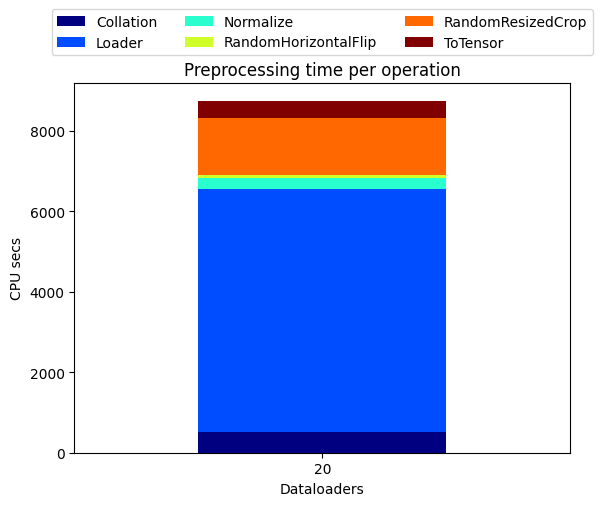

In [88]:
# plot stacked bar chart for each config
all_config_stacked = all_stats_df.groupby(['config', 'Function'])['E2E elapsed time (secs)'].sum().unstack()
all_config_stacked.plot.bar(stacked=True, colormap='jet')
# put legend on top of the plot
plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', borderaxespad=0., ncol=3)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper', borderaxespad=0.,ncol=3)
# y axis is elapsed time in seconds
plt.ylabel('CPU secs')
# x axis is Dataloaders
plt.xlabel('Dataloaders')
# make x axis horizontal
plt.xticks(rotation=0)
# make title 
plt.title('Preprocessing time per operation')
# save the plot
plt.savefig(plot_path, bbox_inches='tight')


In [89]:
# all_config_stacked save as csv
all_config_stacked.to_csv(csv_path)